In [10]:
import sys
import torch
import numpy as np

import os
import glob
import lpips
import urllib
import zipfile
import collections
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Javascript
from IPython.core.display import display, HTML

thirdparty_repo_path = os.path.abspath("/h/lkcai/code/video-perception/hific")
if thirdparty_repo_path not in sys.path:
    sys.path.insert(0, thirdparty_repo_path)

from hific.compress import prepare_model, prepare_dataloader, \
    compress_and_save, load_and_decompress, compress_and_decompress
from UVG1 import UVG

device = torch.device('cuda' if torch.cuda.is_available else cpu)
!nvidia-smi

Sun Dec 15 00:50:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:D8:00.0 Off |                    0 |
| N/A   44C    P0    28W /  70W |   7287MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
model_path = "./saved_models/vimeo-90k/FMD/hific_hi.pt"
log_path = "./hific/log"


print('Building model ...')
model, args = prepare_model(model_path, log_path)
first_model_init = True

00:50:41 INFO - logger_setup: /fs01/home/lkcai/code/video-perception/hific/compress.py
00:50:41 INFO - logger_setup: /fs01/home/lkcai/code/video-perception/hific/compress.py


Building model ...
Building prior probability tables...


100%|██████████| 64/64 [00:00<00:00, 382.59it/s]

Setting up Perceptual loss...



00:50:47 INFO - load_model: Loading model ...
00:50:47 INFO - load_model: Loading model ...
00:50:47 INFO - load_model: Estimated model size (under fp32): 725.903 MB
00:50:47 INFO - load_model: Estimated model size (under fp32): 725.903 MB
00:50:47 INFO - load_model: Model init 5.402s
00:50:47 INFO - load_model: Model init 5.402s


Loading model from: /h/lkcai/code/video-perception/hific/src/loss/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


00:50:47 INFO - prepare_model: Model loaded from disk.
00:50:47 INFO - prepare_model: Model loaded from disk.
00:50:47 INFO - prepare_model: Building hyperprior probability tables...
00:50:47 INFO - prepare_model: Building hyperprior probability tables...
100%|██████████| 320/320 [00:00<00:00, 2389.09it/s]
00:50:52 INFO - prepare_model: All tables built.
00:50:52 INFO - prepare_model: All tables built.


In [12]:
def PSNR(input1, input2):
    mse = torch.mean((input1 - input2) ** 2)
    psnr = 20 * torch.log10(1 / torch.sqrt(mse))
    return psnr.item()

lpips_vgg = lpips.LPIPS(net='vgg').to(device)
def LPIPS(img1, img2):
    img1 = img1 * 2 - 1
    img2 = img2 * 2 - 1
    return lpips_vgg(img1, img2).item()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /h/lkcai/anaconda3/envs/video_perc/lib/python3.6/site-packages/lpips/weights/v0.1/vgg.pth


In [16]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.RandomCrop(256)
])

# uvg_dataset = UVG("./data/uvg/", train_transforms)
# uvg_dataloader = DataLoader(
#     uvg_dataset,
#     batch_size=1,
#     num_workers=0,
#     shuffle=True,
#     pin_memory=True,
# )

PSNR-Img2: 28.100982666015625
LPIPS-Img2: 0.16487757861614227
PSNR-Img3: 28.100982666015625
LPIPS-Img3: 0.16487757861614227
(256, 512, 3) (256, 512, 3)


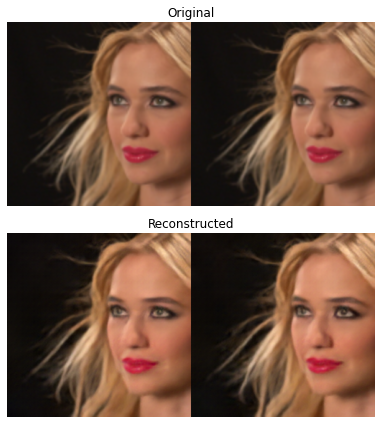

In [24]:
# for data in uvg_dataloader:
#     data = data[0][0].unsqueeze(0).to(device) 
#     print(data.min(), data.max())
#     reconstruction, q_bpp = model(data, writeout=False)
#     reconstruction -= reconstruction.min()
#     reconstruction /= reconstruction.max()
#     print(reconstruction.min(), reconstruction.max())
#     break

img2_path = '/h/lkcai/code/video-perception/reconstructions/R1-eps-uvg/k/x2.png'
img3_path = '/h/lkcai/code/video-perception/reconstructions/R1-eps-uvg/k/x3.png'

img2 = Image.open(img2_path).convert('RGB')
img3 = Image.open(img3_path).convert('RGB')

img2 = train_transforms(img2).unsqueeze(0).cuda()
img3 = train_transforms(img3).unsqueeze(0).cuda()

img2_recon, _ = model(img2, writeout=False)
img3_recon, _ = model(img3, writeout=False)

img2_recon -= img2_recon.min()
img2_recon /= img2_recon.max()
img3_recon -= img3_recon.min()
img3_recon /= img3_recon.max()

print(f"PSNR-Img2: {PSNR(img2, img2_recon)}")
print(f"LPIPS-Img2: {LPIPS(img2, img2_recon)}")
print(f"PSNR-Img3: {PSNR(img2, img2_recon)}")
print(f"LPIPS-Img3: {LPIPS(img2, img2_recon)}")

img2 = img2.squeeze(0).permute(1, 2, 0).cpu().numpy()
img3 = img3.squeeze(0).permute(1, 2, 0).cpu().numpy()

img2_recon = img2_recon.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
img3_recon = img3_recon.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

img = np.concatenate([img2, img3], axis=1)
img_recon = np.concatenate([img2_recon, img3_recon], axis=1)

print(img.shape, img_recon.shape)

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title("Original")

axs[1].imshow(img_recon, cmap=cmap)
axs[1].axis('off')
axs[1].set_title("Reconstructed")

plt.tight_layout()

letter = 'k'
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x2_hat_FMD.png", img2_recon)
plt.imsave(f"./reconstructions/R1-eps-uvg/{letter}/x3_hat_FMD.png", img3_recon)